In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
from datetime import datetime, timedelta
from dateutil.parser import parse
from IPython.display import HTML
from salishsea_tools import nc_tools, places

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

%matplotlib inline

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2919/libparcels_random_e563f8c4-ed96-405e-a257-5a06965087b3.so


In [2]:
plt.rcParams['font.size'] = 12

In [3]:
def fieldset_from_nemo(daterange, coords, flat=True):
    """Generate a fieldset from a hourly SalishSeaCast forcing fields
    over daterange.
    """

    # Generate sequential list of forcing file prefixes
    prefixes = [
        nc_tools.get_hindcast_prefix(daterange[0] + timedelta(days=d))
        for d in range(np.diff(daterange)[0].days + 1)
    ]

    # Predefine fieldset argument dictionaries
    filenames, variables, dimensions = {}, {}, {}

    # Define dict fields for each variable
    for var, name in zip(['U', 'V', 'W'], ['vozocrtx', 'vomecrty', 'vovecrtz']):
        
        # Exclude vertical velocity if 2D
        if flat:
            if var == 'W': break

        # Dict of filenames containing the coordinate and forcing variables
        datafiles = [prefix + f'_grid_{var}.nc' for prefix in prefixes]
        filenames[var] = {'lon': coords, 'lat': coords, 'data': datafiles}

        # NEMO variable name
        variables[var] = name

        # Dict of NEMO coordinate names (f-points)
        dimensions[var] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        
        # Add depth fields if 3D (f-points are on W grid)
        if not flat:
            filenames[var]['depth'] = prefixes[0] + '_grid_W.nc'
            dimensions[var]['depth'] = 'depthw'

    # Load NEMO forcing into fieldset
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)# field_chunksize='auto')
    
    return field_set

In [4]:
def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

In [5]:
# Paths and filenames
paths = {
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    #'results': '/data/bmoorema/results/parcels/sandbox',
    'results': './results',
}

# Load coords and mask files and extract grid variables
coords, mask = [xr.open_dataset(paths[key], decode_times=False) for key in ('coords', 'mask')]
gridlon, gridlat = [coords[key][0, ...].values for key in ('glamt', 'gphit')]
tmask = mask.tmask[0, 0, ...].values

# Define release parameters
location = 'Central SJDF'
n = 1   # number of particles
r = 50   # radius of particle cloud [m]

# Start time, duration and timestep
start = datetime(2019, 1, 1, 12, 30, 0)
duration = timedelta(days=3)
dt = timedelta(seconds=90)

# Create Gaussian distribution around release point
mean, cov = [0, 0], [[r**2, 0], [0, r**2]]
x_offset, y_offset = np.random.multivariate_normal(mean, cov, n).T
lon, lat = places.PLACES[location]['lon lat']
lons = lon + x_offset / 111000 / np.cos(np.deg2rad(lat))
lats = lat + y_offset / 111000

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

# # Output file prefix
# strings = [location] + [t.strftime('%Y%m%dT%H%M%S') for t in (start, start + duration)]
# prefix = os.path.join(paths['results'], '_'.join(strings))

# Set output file name.  Maybe change for each run
fn = f'JDFeastBDY' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

./results/JDFeastBDY20190101_1n_20190104_1n.nc


In [6]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], flat=False)

         It will be opened with no decoding. Filling values might be wrongly parsed.


In [7]:
# Execute NEMO-only, 3D run, release at 5m
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lons, lat=lats, depth=np.repeat(5, n), time=np.repeat(start, n))
#kernel = AdvectionRK4_3D
#outputfile = pset.ParticleFile(name=prefix + '_NEMO_3D.nc', outputdt=timedelta(hours=1))
# pset.execute(
#     kernel, runtime=duration, dt=dt, output_file=output_file,
#     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
# )
pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-2919/4e2f69f2a172376364c8ebb1c7e74d76_0.so
INFO: Temporary output files are stored in ./results/out-SUCNWSQA.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-SUCNWSQA" to convert these to a NetCDF file during the run.
100% (259200.0 of 259200.0) |############| Elapsed Time: 0:01:55 Time:  0:01:55


In [8]:
# Had this cell earlier before but seem to need to run it after simulationto get the outputfiles 
# from the temp directory into my final outfile
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [9]:
data = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

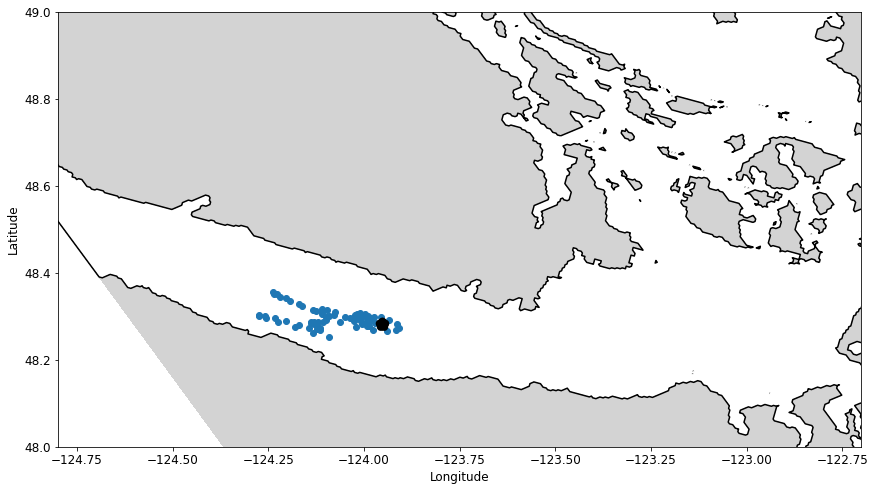

In [10]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax.scatter(data.lon[traj, nmin:nmax], data.lat[traj, nmin:nmax])
ax.scatter(lon,lat,c='k', marker='*', linewidths=8)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

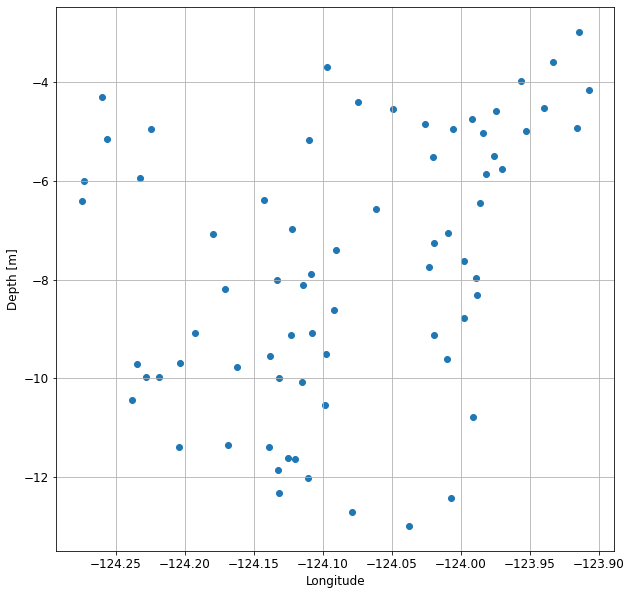

In [11]:
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n):
    s = ax.scatter(data.lon[traj, nmin:nmax], -data.z[traj, nmin:nmax])
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

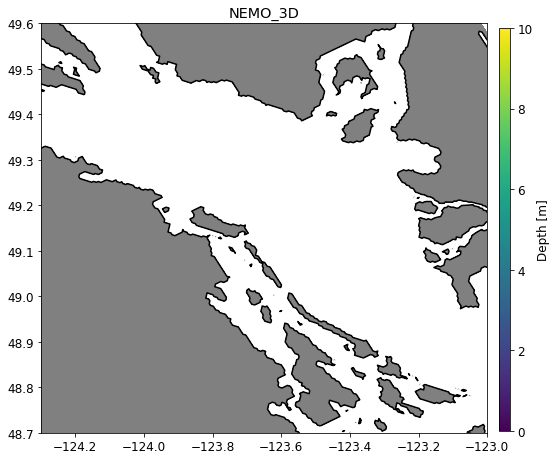

In [13]:
# # Make initial figure
# fig, ax = plt.subplots(figsize=(8, 8))
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=10, edgecolor='k')
# t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
# data = xr.open_dataset(prefix + '_NEMO_3D.nc')
# ax.contourf(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='gray')
# ax.contour(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='k')
# ax.set_xlim([-124.3, -123])
# ax.set_ylim([48.7, 49.6])
# ax.set_title('NEMO_3D')
# ax.set_aspect(1/np.sin(np.deg2rad(49)))
# fig.colorbar(l, cax=cax, label='Depth [m]')

# # Init function
# def init():
#     t.set_text('')
#     l.set_offsets(np.empty((0, 2)))
#     l.set_array(np.empty(0))
#     return l, t,

# # Animate function
# def animate(hour):
#     tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
#     t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
#     l.set_offsets(np.vstack([data.lon[:, hour], data.lat[:, hour]]).T)
#     l.set_array(data.z[:, hour])
#     return l, t,

# # Build animation
# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=73, interval=100, blit=True)

In [14]:
# # Render animation
# HTML(anim.to_html5_video())